In [41]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error

In [42]:
weather_df = pd.read_csv(r'C:\Users\ASUS\Documents\nagpur.csv\seattle_weather_1948-2017.csv')
weather_df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [43]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    25551 non-null  object 
 1   PRCP    25548 non-null  float64
 2   TMAX    25551 non-null  int64  
 3   TMIN    25551 non-null  int64  
 4   RAIN    25548 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


In [44]:
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
weather_df.set_index('DATE', inplace=True)

In [45]:
print(weather_df.head())

            PRCP  TMAX  TMIN  RAIN
DATE                              
1948-01-01  0.47    51    42  True
1948-01-02  0.59    45    36  True
1948-01-03  0.42    45    35  True
1948-01-04  0.31    45    34  True
1948-01-05  0.17    45    32  True


In [46]:
training_start_date = '2005-01-01'
training_end_date = '2015-12-31'
testing_start_date = '2016-01-01'
testing_end_date = '2017-01-01'

In [47]:
training_data1 = weather_df.loc[training_start_date:training_end_date]
testing_data1 = weather_df.loc[testing_start_date:testing_end_date]

In [48]:
features = ['TMAX', 'TMIN']  # Features to be used for modeling
target_variable = 'TMAX'

In [49]:
X_train = training_data1.drop(columns=[target_variable])
y_train = training_data1[target_variable]

In [50]:
X_test = testing_data1.drop(columns=[target_variable])
y_test = testing_data1[target_variable]

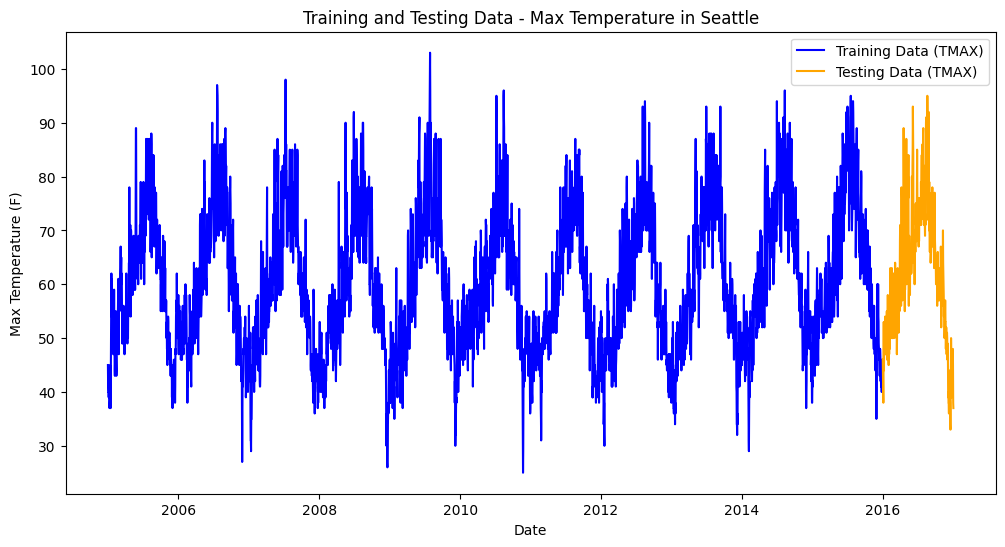

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(training_data1.index, training_data1[target_variable], label='Training Data (TMAX)', color='blue')
plt.plot(testing_data1.index, testing_data1[target_variable], label='Testing Data (TMAX)', color='orange')

plt.title('Training and Testing Data - Max Temperature in Seattle')
plt.xlabel('Date')
plt.ylabel('Max Temperature (F)')
plt.legend()
plt.show()

In [52]:
def train_arima_model(data, feature):
    model = ARIMA(data[feature], order=(5,1,0))
    arima_model = model.fit()
    return arima_model

In [53]:
def forecast_stl(data, feature, steps):
    stl = STL(data[feature], seasonal=13)
    res = stl.fit()
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    # Forecast by adding the trend and seasonal components
    forecast = trend + seasonal
    
    return forecast[-steps:]

In [54]:
for feature in features:
    # ARIMA
    arima_model = train_arima_model(training_data1, feature)
    arima_forecast = arima_model.forecast(steps=len(testing_data1))
    
    # STL
    stl_forecast = forecast_stl(training_data1, feature, len(testing_data1))
    
    # Evaluate models using Mean Squared Error (MSE)
    arima_mse = mean_squared_error(testing_data1[feature], arima_forecast)
    stl_mse = mean_squared_error(testing_data1[feature], stl_forecast)
    
    print(f"\nMean Squared Error (MSE) for {feature}:")
    print(f"ARIMA: {arima_mse}")
    print(f"STL: {stl_mse}")


Mean Squared Error (MSE) for TMAX:
ARIMA: 579.0383389473027
STL: 60.705747390194695

Mean Squared Error (MSE) for TMIN:
ARIMA: 370.4266338693992
STL: 28.274985428394224


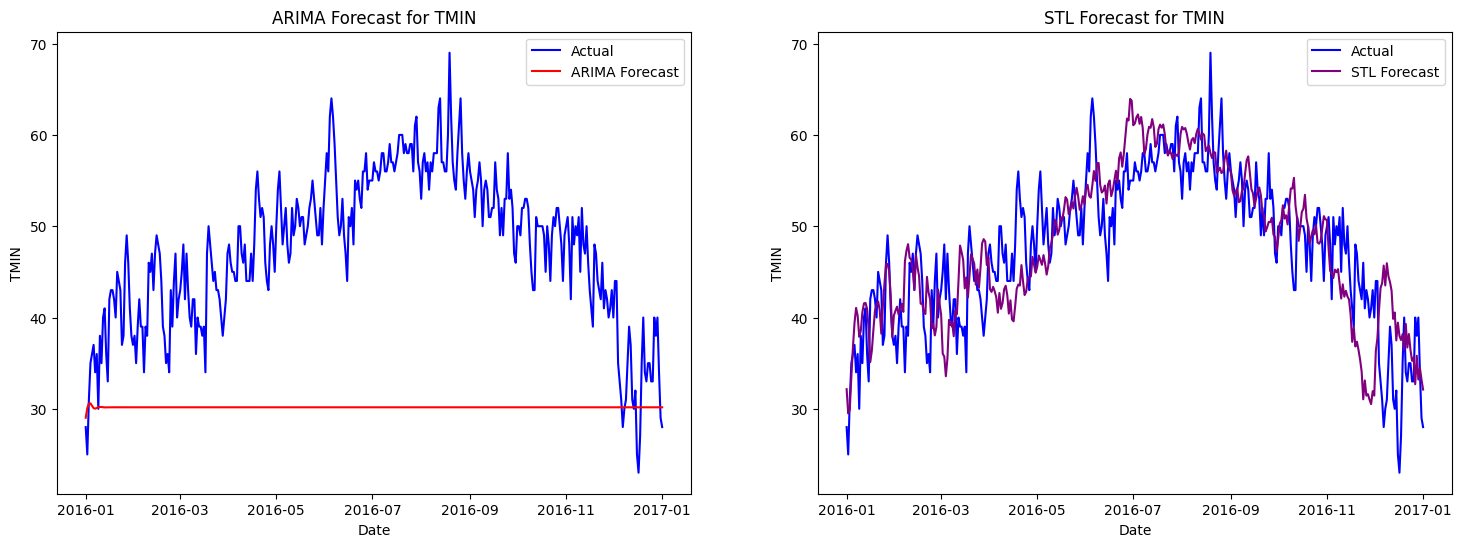

In [68]:
plt.figure(figsize=(18, 6))
# Plot ARIMA forecast
plt.subplot(1, 2, 1)
plt.plot(testing_data1.index, testing_data1[feature], label='Actual', color='blue')
plt.plot(testing_data1.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title(f"ARIMA Forecast for {feature}")
plt.xlabel("Date")
plt.ylabel(feature)
plt.legend()

# Plot STL forecast
plt.subplot(1, 2, 2)
plt.plot(testing_data1.index, testing_data1[feature], label='Actual', color='blue')
plt.plot(testing_data1.index, stl_forecast, label='STL Forecast', color='purple')
plt.title(f"STL Forecast for {feature}")
plt.xlabel("Date")
plt.ylabel(feature)
plt.legend()

plt.show()

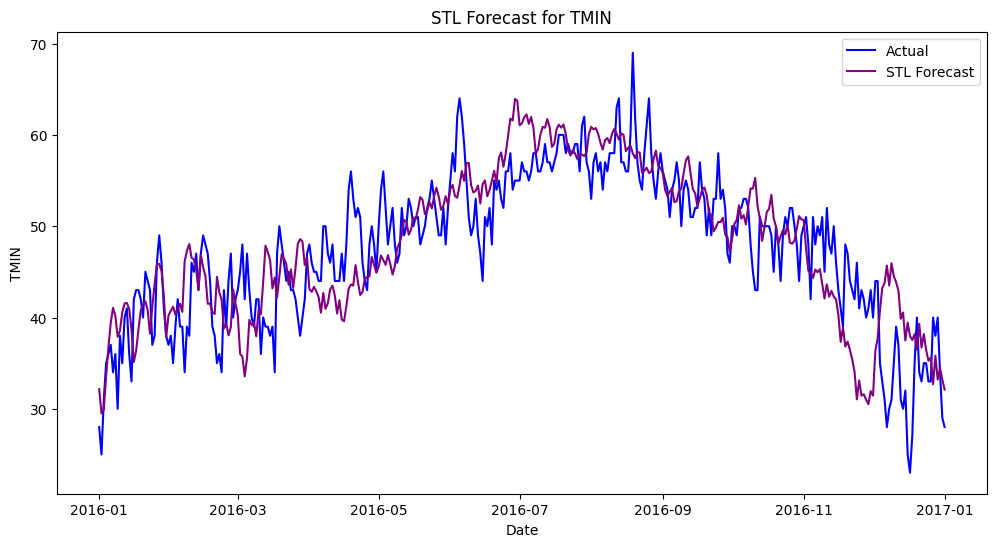

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(testing_data1.index, testing_data1[feature], label='Actual', color='blue')
plt.plot(testing_data1.index, stl_forecast, label='STL Forecast', color='purple')
plt.title(f"STL Forecast for {feature}")
plt.xlabel("Date")
plt.ylabel(feature)
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import r2_score


In [58]:
arima_r2 = r2_score(testing_data1[feature], arima_forecast)

In [59]:
n = len(testing_data1[feature])
p = 1  # Number of features (assuming only the lagged variable)
arima_adjusted_r2 = 1 - ((1 - arima_r2) * (n - 1) / (n - p - 1))

In [60]:
stl_r2 = r2_score(testing_data1[feature], stl_forecast)

In [61]:
stl_adjusted_r2 = 1 - ((1 - stl_r2) * (n - 1) / (n - p - 1))

In [62]:
print(f"R-squared (R2) for ARIMA model: {arima_r2}")
print(f"Adjusted R-squared (adjusted R2) for ARIMA model: {arima_adjusted_r2}")
print(f"R-squared (R2) for STL model: {stl_r2}")
print(f"Adjusted R-squared (adjusted R2) for STL model: {stl_adjusted_r2}")

R-squared (R2) for ARIMA model: -4.453024473411689
Adjusted R-squared (adjusted R2) for ARIMA model: -4.4679642664895285
R-squared (R2) for STL model: 0.5837659243996125
Adjusted R-squared (adjusted R2) for STL model: 0.5826255570692005
